# Predicciones de vinos: Combinando modelos
### Daniel Marín López

---

1. Importamos librerías y cargamos variables globales
2. Cargamos los datos
3. Visualizamos los datos
4. Preprocesamiento de los datos
5. Validación cruzada, búsqueda de los mejores hiperparámetros
6. Creación del modelo `VotingClassifier`
7. Pruebas y evaluación
8. Conclusión

### 1. Importamos librerías y cargamos variables globales

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
import sklearn
import pickle
import joblib
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from imblearn.pipeline import Pipeline as imbpipeline

In [ ]:
SEED = 42
TEST = 0.2

In [ ]:
path = kagglehub.dataset_download("uciml/red-wine-quality-cortez-et-al-2009")

print("Path to dataset files:", path)

!mv /root/.cache/kagglehub/datasets/uciml/red-wine-quality-cortez-et-al-2009/versions/2/winequality-red.csv /content/winequality-red.csv

100%|██████████| 25.6k/25.6k [00:00<00:00, 13.9MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/uciml/red-wine-quality-cortez-et-al-2009/versions/2


### 2. Cargamos los datos

In [ ]:
df_wines = pd.read_csv("/content/winequality-red.csv")
df_wines.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


### 3. Visualización de los datos

In [ ]:
df_wines.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [ ]:
df_wines.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


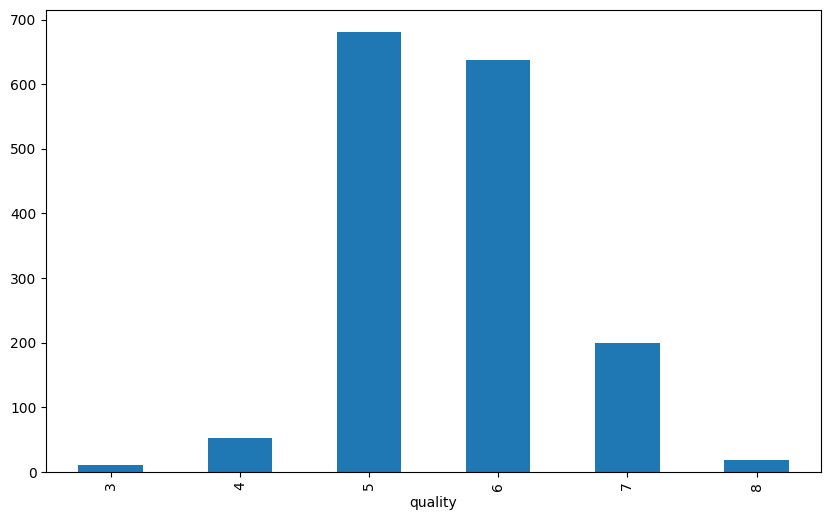

In [ ]:
plt.figure(figsize=(10, 6))
df_wines["quality"].value_counts().sort_index().plot(kind="bar")
plt.show()

### 4. Preprocesamiento de los datos

El preprocesamiento será el mismo que en la práctica de KNN. Haremos primero la división entre entrenamiento y prueba, luego haremos SMOTE para el balanceo y finalmente escalaremos los datos.

In [ ]:
X = df_wines.drop('quality', axis=1)
y = df_wines['quality']

X_train_wine, X_test_wine, y_train_wine, y_test_wine = train_test_split(X, y, test_size=TEST, random_state=SEED)

In [ ]:
smote = SMOTE(random_state=SEED)
X_train_res, y_train_res = smote.fit_resample(X_train_wine, y_train_wine)

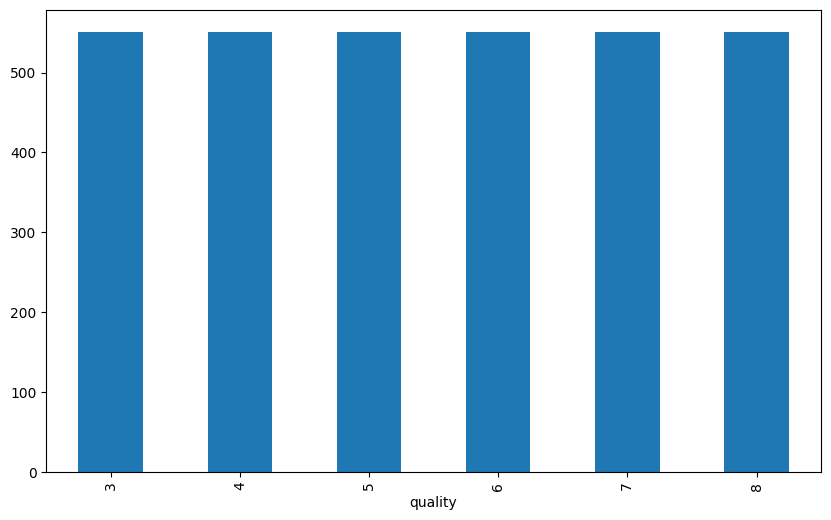

In [ ]:
plt.figure(figsize=(10, 6))
y_train_res.value_counts().sort_index().plot(kind="bar")
plt.show()

In [ ]:
std_scaler = StandardScaler()
X_train_wines_std = std_scaler.fit_transform(X_train_res)
X_test_wines_std = std_scaler.transform(X_test_wine)

### 5. Validación cruzada, busqueda de los mejores hiperparámetros

Para buscar los mejores hiperparámetros en cada modelo, crearemos un diccionario con los modelos donde dentro hay un diccionario por cada modelo que tienen el modelo y los hiperparámetros que usaremos para la validación cruzada. Luego iremos recorriendo el diccionario principal y por cada modelo se le pasará a la validación cruzada el diccionario con el modelo y los hiperparámetros.

Luego, tras terminar la validación cruzada, se imprimen los hiperpárametros junto a la score que han obtenido. Los modelos que usaremos serán los siguientes:

* KNN
* RandomForest
* SVC
* Regresión Lógistica
* SGD
* Gradient Boosting
* Ada Boostig (propuesto por Gemini)

In [ ]:
models = {
    'KNeighborsClassifier': {
        'model': KNeighborsClassifier(),
        'params': {
            'n_neighbors': [3, 5, 7, 9],
            'weights': ['uniform', 'distance'],
            'metric': ['euclidean', 'manhattan']
        }
    },
    'RandomForestClassifier': {
        'model': RandomForestClassifier(random_state=SEED),
        'params': {
            'n_estimators': [100, 200, 300],
            'max_depth': [None, 5, 10],
            'min_samples_split': [2, 5, 10]
        }
    },
    'SVC': {
        'model': SVC(random_state=SEED),
        'params': {
            'C': [0.1, 1, 10],
            'kernel': ['linear', 'rbf', 'poly'],
            'gamma': ['scale', 'auto']
        }
    },
    'LogisticRegression': {
        'model': LogisticRegression(random_state=SEED),
        'params': {
            'C': [0.1, 1, 10],
            'penalty': [None, 'l2'],
            'solver': ['lbfgs', 'newton-cg', 'sag']
        }
    },
    'SGDClassifier': {
        'model': SGDClassifier(random_state=SEED),
        'params': {
            'loss': ['hinge', 'log_loss'],
            'penalty': ['l2', 'l1'],
            'alpha': [0.0001, 0.001, 0.01]
        }
    },
    'GradientBoostingClassifier': {
        'model': GradientBoostingClassifier(random_state=SEED),
        'params': {
            'n_estimators': [100, 200, 300],
            'learning_rate': [0.1, 0.05, 0.01],
            'max_depth': [3, 5, 7]
        }
    },
    'AdaBoostClassifier': {
        'model': AdaBoostClassifier(random_state=SEED),
        'params': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.1, 0.5, 1.0]
        }
    }
}


for model_name, model_info in models.items():
    grid_search = GridSearchCV(estimator=model_info['model'], param_grid=model_info['params'],
                              cv=5, scoring='accuracy', n_jobs=-1)

    grid_search.fit(X_train_wines_std, y_train_res)

    print(f"{model_name}: Best parameters: {grid_search.best_params_}, Best score: {grid_search.best_score_}")


KNeighborsClassifier: Best parameters: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}, Best score: 0.8505788629331189
RandomForestClassifier: Best parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 300}, Best score: 0.8747763847690262
SVC: Best parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}, Best score: 0.8384814731867399
LogisticRegression: Best parameters: {'C': 1, 'penalty': 'l2', 'solver': 'newton-cg'}, Best score: 0.6113167360631836
SGDClassifier: Best parameters: {'alpha': 0.001, 'loss': 'log_loss', 'penalty': 'l1'}, Best score: 0.5886307023597863
GradientBoostingClassifier: Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300}, Best score: 0.8711546635830543
AdaBoostClassifier: Best parameters: {'learning_rate': 0.1, 'n_estimators': 100}, Best score: 0.4655136637247419


### 6. Creación del modelo VotingClassifier

Creamos el modelo en donde asignamos los estimadores/modelos junto a los hiperparámetros obtenidos anteriormente.

In [ ]:
voting_vinos = VotingClassifier(
    estimators = [
        ('knn', KNeighborsClassifier(metric='manhattan', n_neighbors=3, weights='distance')),
        ('rf', RandomForestClassifier(max_depth=None, min_samples_split=2, n_estimators=300, random_state=SEED)),
        ('svc', SVC(C=10, gamma='scale', kernel='rbf', random_state=SEED)),
        ('lr', LogisticRegression(C=1, penalty='l2', solver='newton-cg', random_state=SEED)),
        ('sgd', SGDClassifier(alpha=0.001, loss='log_loss', penalty='l1', random_state=SEED)),
        ('gbc', GradientBoostingClassifier(learning_rate=0.1, max_depth=5, n_estimators=300, random_state=SEED)),
        ('ada', AdaBoostClassifier(learning_rate=0.1, n_estimators=100, random_state=SEED)),

    ]
)

Luego, entrenamos el modelo. Antes de entrenar tenemos que indicar la siguiente configuración al modelo.

* `voting_vinos.voting = "soft"`: Este tipo de votación hará que cada clasificador predizca la probabilidad de cada clase y `VotingClassifier` escogerá la clase con la probabilidad promedio más alta entre todos los clasificadores. Los resultados son más precisos que si fuera `hard`.
* `voting_vinos.named_estimators["svc"].probability = True`: Debemos habilitar al modelo SVC la capacidad de estimar probabilidades de clase ya que la votación `soft` requiere que todos los modelos proporcionen probabilidades.

#### ¿Cómo sé que modelos pueden dar probabilidades y cuáles no?

Lo cierto es que no es fácil saber que modelos pueden dar probabilidades, según Gemini se puede hacer de dos formas:

* Buscar el atributo `predict_proba`: Si un modelo tiene el atributo predict_proba, significa que puede calcular probabilidades.
* Mirar la documentación: La documentación de scikit-learn para cada modelo especifica si soporta probabilidades o no.

In [ ]:
voting_vinos.voting = "soft"
voting_vinos.named_estimators["svc"].probability = True
voting_vinos.fit(X_train_wines_std, y_train_res)
voting_vinos.score(X_test_wines_std, y_test_wine)

0.640625

### 7. Pruebas y rendimiento

Imprimos el desempeño de cada modelo.

In [ ]:
for name, model in voting_vinos.named_estimators_.items():
    print(name + " score: {:.2f}".format(model.score(X_test_wines_std, y_test_wine)))

knn score: 0.00
rf score: 0.00
svc score: 0.00
lr score: 0.02
sgd score: 0.03
gbc score: 0.00
ada score: 0.01


Vemos que los desempeños son muy bajos o nulos. Por lo que vamos a revisar el desempeño del modelo en general.

In [ ]:
y_predict_vinos = voting_vinos.predict(X_test_wines_std)

print(classification_report(y_test_wine, y_predict_vinos))

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         1
           4       0.16      0.30      0.21        10
           5       0.77      0.72      0.74       130
           6       0.69      0.62      0.66       132
           7       0.55      0.62      0.58        42
           8       0.08      0.20      0.12         5

    accuracy                           0.64       320
   macro avg       0.38      0.41      0.38       320
weighted avg       0.68      0.64      0.66       320



El desempeño obtenido es de un 64%. Un poco mejor a los desempeños obtenidos con KNN que eran de 54% para el modelo clasificatorio y 58% para el modelo regresor. Veamos como es la matriz de confusión.

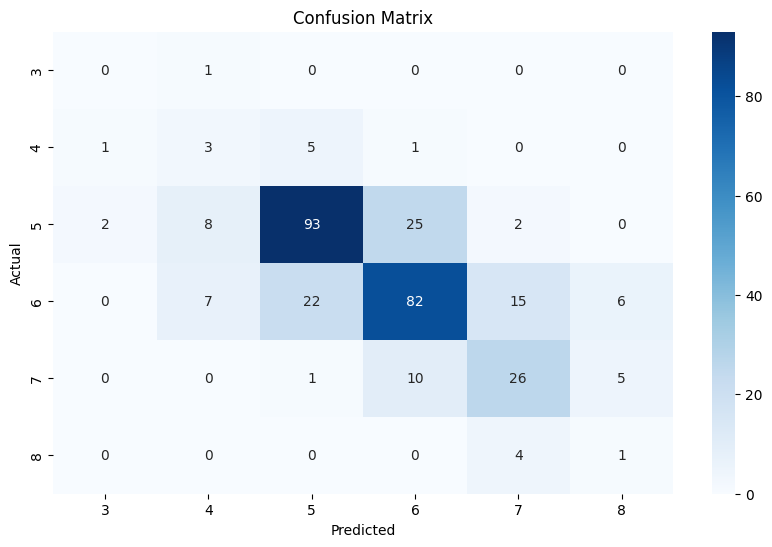

In [ ]:
cm_vinos = confusion_matrix(y_test_wine, y_predict_vinos)

CLASSES = np.unique(y_test_wine)

plt.figure(figsize=(10, 6))
sns.heatmap(cm_vinos, annot=True, fmt='d', cmap='Blues', xticklabels=CLASSES, yticklabels=CLASSES)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


Vemos que la matriz de confusión se parece un poco a la de KNN, pero vemos que ha acertado un poco mejor algunas clases que el KNN había fallado más.

### 8. Conclusión

Tras haber realizado el ejercicio, hemos visto que el desempeño de este modelo es mucho mejor que el KNN.

Por lo que parece que la estrategia de tener muchos modelos que voten para predecir las clases de los vinos es mucho más efectiva que con un modelo solo, también nos indica que problemas en donde un modelo tenga dificultades para resolverlo puede ser mejor abordarlo con más modelos que puedan aportar su granito de arena para mejorar el desempeño de nuestro modelo general.